<h2><p>THIS IS A SYSTEM THAT DETECTS PNEUMONIA FROM IMAGES OF CHEST X-RAY. THE DATASET HAS BEEN DOWNLOADED FROM KAGGLE. I HAVE USED A CONVOLUTIONAL NEURAL NETWORK TO TACKLE WITH THIS PROBLEM.</p></h2>

DATASET LINK - https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

ABOUT THE DATASET: 

The dataset was already split into train, cross-validation and test set. However, the main problem with the predefined split was that instead of a standard split of 70-15-15 (Balanced Split), the validation set was around 0.27% of the dataset. Training a neural network with this split would give very bad results no matter what hyperparameter tuning or regularization I do.
So, ultimately I did my own split of 70-20-10 on the dataset.

In [1]:
# Importing all required packages.
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, auc
import tensorflow as tf
from tensorflow.python.keras import backend as K
import os
import random

In [2]:
# In order to apply similar randomness to every random operation, I will set the random seed to a constant value.
my_seed = 42
os.environ['PYTHONHASHSEED'] = str(my_seed) # Python random hashing environment variable. This is randomly salted for security reasons but it is not required here.
random.seed(my_seed) # Pythons in-built random library seed.
np.random.seed(my_seed) # Numpy random seed
tf.random.set_seed(my_seed) # Tensorflow random seed.
# I decided to set all seeds to random at the start of the code to avoid confusion later.

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
my_sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(my_sess)

In [3]:
# Time to generate the train, validation and test sets along with data augmentation.
# Let's set some hyperparameters that may be changed later.
my_batch = 128
my_epochs = 100
my_dimensions = 64 # The images generated will be of 64 x 64 dimensions
num_channels = 1 # Grayscale image has 1 channel (RGB has 3)
my_color_mode = "grayscale" # No need to waste computations on RGB data. For X-Ray applications, grayscale is enough.
# Setting the file paths in variables for later use
projectPath = "B:\\My ML Projects\\Pneumonia Dataset"
trainPath = projectPath+"\\chest_xray\\train"
valPath = projectPath + "\\chest_xray\\val"
testPath = projectPath + "\\chest_xray\\test"

# Data Augmentaion to increase the amount of data.
train_augmented = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0, horizontal_flip=True, shear_range=0.2, zoom_range=0.2)
val_augmented = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0) 
test_augmented = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0)
# Note that I did not apply augmentation to the cross-validation and test sets because we don't train the CNN on test data and most of the data is in the test set. So this should be good enough.
# Now that the constructor has done it's job, time to generate the data by a method in this class.

train_generate = train_augmented.flow_from_directory(directory=trainPath, batch_size=my_batch, target_size=(my_dimensions,my_dimensions), color_mode=my_color_mode, class_mode='binary', seed=my_seed)
val_generate = val_augmented.flow_from_directory(directory=valPath, batch_size=my_batch, target_size=(my_dimensions,my_dimensions),shuffle=False, color_mode=my_color_mode, class_mode='binary', seed=my_seed)
test_generate = test_augmented.flow_from_directory(directory=testPath, batch_size=my_batch, target_size=(my_dimensions,my_dimensions),shuffle=False, color_mode=my_color_mode, class_mode='binary', seed=my_seed)
test_generate.reset()

Found 4100 images belonging to 2 classes.
Found 1172 images belonging to 2 classes.
Found 584 images belonging to 2 classes.


In [4]:
# Now let's train the above shown convolutional neural network and see how it works
# Defining the architechture
conv_nn = tf.keras.Sequential([
    tf.keras.Input(shape=(my_dimensions,my_dimensions,num_channels)),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),  # MaxPooling dimensions by default are 2x2 so no need to mention in arguments
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),  # Flattens the output of conv layers to feed it to fully connected layers.
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='sigmoid')]
)

In [5]:
# Defining the Loss Function and Optimizer
conv_nn.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics=[tf.keras.metrics.AUC()]
               )

In [6]:
# Training the model
trained_cnn = conv_nn.fit(
    x=train_generate,
    epochs=my_epochs,
    validation_data=val_generate
)

Epoch 1/100


33/33 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - auc: 0.4915 - loss: 0.6094 - val_auc: 0.6791 - val_loss: 0.5431
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 28s 717ms/step - auc: 0.6379 - loss: 0.5688 - val_auc: 0.8951 - val_loss: 0.4245
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 27s 692ms/step - auc: 0.8692 - loss: 0.4083 - val_auc: 0.9701 - val_loss: 0.5660
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 27s 675ms/step - auc: 0.9190 - loss: 0.3187 - val_auc: 0.9728 - val_loss: 0.2352
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 26s 663ms/step - auc: 0.9494 - loss: 0.2511 - val_auc: 0.9817 - val_loss: 0.2134
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 28s 711ms/step - auc: 0.9612 - loss: 0.2170 - val_auc: 0.9888 - val_loss: 0.2891
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 27s 678ms/step - auc: 0.9615 - loss: 0.2189 - val_auc: 0.9848 - val_loss: 0.1522
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 27s 710ms/step - auc: 0.9571 - loss: 0.2316 - val_auc: 0.9839 - val_loss: 0.2071
Epoch 9/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 27s 721ms/step -

In [7]:
trained_cnn.history.keys() # Getting the key names for the history dictionary

dict_keys(['auc', 'loss', 'val_auc', 'val_loss'])

In [8]:
# Now that training is done, let's measure it's perfomance using some metrics and graphs
def generate_graphs():
    # Train and Val Losses for each epoch
    training_loss = trained_cnn.history['loss']
    validation_loss = trained_cnn.history['val_loss']

    #Train and Val AUC scores for each epoch
    training_auc_scores = trained_cnn.history['auc']
    validation_auc_scores = trained_cnn.history['val_auc']

    # Get the predictions on Test Set
    y_true = test_generate.classes
    Y_pred = conv_nn.predict(test_generate,steps=len(test_generate))
    y_pred_probas = Y_pred.T[0]
    y_pred = (Y_pred > 0.5).T[0]

    # Graphs
    main_plot = plt.figure(figsize=(13,10))
    # Sub-Plot 1: Training Loss vs Cross-Validation Loss
    plt.subplot(2,2,1)
    plt.title("TRAINING LOSS vs CROSS-VALIDATION LOSS")
    plt.plot(training_loss,label="Training Loss")
    plt.plot(validation_loss, label ="Cross-Validation Loss")
    plt.xlabel("Number of Epochs")
    plt.legend()

    #Sub-Plot 2: Train AUC vs Cross-Val AUC
    plt.subplot(2,2,2)
    plt.title("TRAINING AUC vs CROSS-VALIDATION AUC")
    plt.plot(training_auc_scores,label="Training AUC Scores")
    plt.plot(validation_auc_scores,label="Cross-Validation AUC Scores")
    plt.xlabel("Number of Epochs")
    plt.legend()

    #Sub-Plot 3: Confusion Matrix
    plt.subplot(2,2,3)
    cm = confusion_matrix(y_true, y_pred)
    names = ['True Negatives', 'False Positives', 'False Negatives', 'True Positives']
    counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
    labels = np.asarray(labels).reshape(2,2)
    ticklabels = ['Normal', 'Pneumonia']

    sns.set(font_scale = 1.4)
    ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Oranges', xticklabels=ticklabels, yticklabels=ticklabels )
    plt.xticks(size=12)
    plt.yticks(size=12)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted", size=14)
    plt.ylabel("Actual", size=14) 
    
    #Sub-Plot 4: ROC Curve
    plt.subplot(2,2,4)
    false_pos_rate, true_pos_rate, threshold = roc_curve(y_true,y_pred_probas)
    roc_auc = roc_auc_score(y_true, y_pred_probas)
    plt.title("Region of Convergence")
    plt.plot([0,1],[0,1],'k--',label="Random ROC Curve(50%)")
    plt.plot(false_pos_rate,true_pos_rate,label="My CNN-> (AUC={:.2f}%)".format(roc_auc*100))
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc='best')

    plt.tight_layout()

    # Final Summary
    TN, FP, FN, TP = cm.ravel()
    accuracy = (TP+TN)/np.sum(cm)
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    f1_score = (2*precision*recall)/(precision+recall)
    stats_summary = '[Summary Statistics]\nAccuracy = {:.2%} | Precision = {:.2%} | Recall = {:.2%} | F1 Score = {:.2%}'.format(accuracy, precision, recall, f1_score)
    print(stats_summary)

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 828ms/step
[Summary Statistics]
Accuracy = 88.01% | Precision = 84.56% | Recall = 99.19% | F1 Score = 91.29%


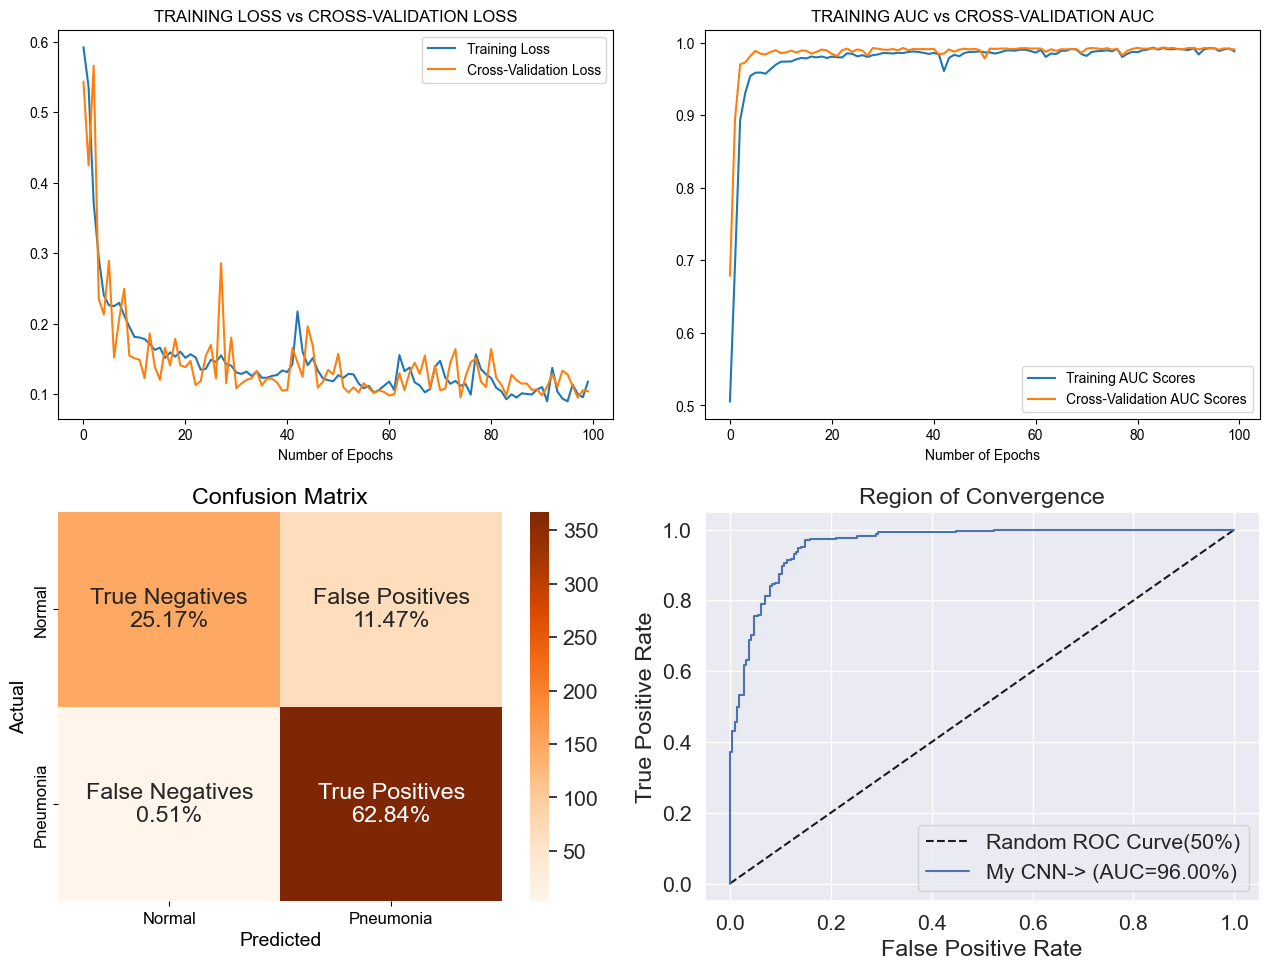

In [9]:
generate_graphs()

In [20]:
conv_nn.save("Pneumonia_CNN.keras")